# Sentiment Classification on Amazon Reviews
## AML2304 - Natural Language Processing
### Assignment 1

* Andrea Franco C0931897
* Andres Salguero C0932873
* Pallavi Sathyanarayana C0938530
* Uma Varadaraj C0935831
* Mohd kaif malik C0935556



# Summary

As the amount of textual data increases through the years due to the popularization of social media, e-commerce platforms and other data sources, sentiment analysis has become an important task and subfield of Natural Language Processing (NLP).

This project aims to evaluate the performance of different classification models, such as Logistic Regression and Random Forest, using two vectorization techniques (Bag of Words and TFF-IDF) for sentiment classification of data containing Amazon Reviews about Healthcare and personal products. This data was cleaned using NLP pre-processing techniques to ensure uniformity, noise reduction and correct tokenization and labelling and used to feed the mentioned models. 

Results showed that Logistic Regression using TF-IDF as the vectorization technique outperformed all the other combinations executed, achieving the highest accuracy and F1-Score. However, these results didn’t surpass the score of 0.80, which suggests that further enhancements can be performed by employing more advanced text representations, training in more robust models and handling class imbalance more effectively.


# Libraries

In [3]:
import gdown
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Data pre preprocessing

Data source: https://amazon-reviews-2023.github.io/#what-s-new

Google drive link: https://drive.google.com/uc?id=1x9EhE6q0RDynrcEU4cmY7L3R8_Qcf9gq

In [4]:
# Google Drive file ID
file_id = "1x9EhE6q0RDynrcEU4cmY7L3R8_Qcf9gq"
# Create the Google Drive download link
download_url = f"https://drive.google.com/uc?id={file_id}"
# Download the CSV file
output_path = "amazon_reviews.csv"
gdown.download(download_url, output_path, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1x9EhE6q0RDynrcEU4cmY7L3R8_Qcf9gq
From (redirected): https://drive.google.com/uc?id=1x9EhE6q0RDynrcEU4cmY7L3R8_Qcf9gq&confirm=t&uuid=0d23f104-447c-4f00-bc99-b978bedd039f
To: /content/amazon_reviews.csv
100%|██████████| 157M/157M [00:00<00:00, 234MB/s]


'amazon_reviews.csv'

In [5]:
df = pd.read_csv(output_path)
df.head()

,rating,title,text,images,asin,parent_asin,user_id,timestamp,helpful_vote,verified_purchase
0,4.0,12 mg is 12 on the periodic table people! Mg f...,This review is more to clarify someone else’s ...,[],B07TDSJZMR,B07TDSJZMR,AFKZENTNBQ7A7V7UXW5JJI6UGRYQ,1580950175902,3,True
1,5.0,Save the lanet using less plastic.,Love these easy multitasking bleach tablets. B...,[],B08637FWWF,B08637FWWF,AEVWAM3YWN5URJVJIZZ6XPD2MKIA,1604354586880,3,True
2,5.0,Fantastic,I have been suffering a couple months with hee...,[],B07KJVGNN5,B07KJVGNN5,AHSPLDNW5OOUK2PLH7GXLACFBZNQ,1563966838905,0,True
3,4.0,It holds the water and makes bubbles. That's ...,"It's cheap and it does what I wanted. The ""ma...",[],B007HY7GC2,B092RP73CX,AEZGPLOYTSAPR3DHZKKXEFPAXUAA,1662258542725,7,True
4,1.0,Not for me,Didn't do a thing for me. Not saying they don'...,[],B08KYJLF5T,B08KYJLF5T,AEQAYV7RXZEBXMQIQPL6KCT2CFWQ,1642722787262,0,True


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 494121 entries, 0 to 494120
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   rating             494121 non-null  float64
 1   title              493996 non-null  object 
 2   text               493980 non-null  object 
 3   images             494121 non-null  object 
 4   asin               494121 non-null  object 
 5   parent_asin        494121 non-null  object 
 6   user_id            494121 non-null  object 
 7   timestamp          494121 non-null  int64  
 8   helpful_vote       494121 non-null  int64  
 9   verified_purchase  494121 non-null  bool   
dtypes: bool(1), float64(1), int64(2), object(6)
memory usage: 34.4+ MB


## Find null values

In [7]:
# Check for missing values (nulls) in each column
null_values = df.isnull().sum()

# Display columns with null values and their counts
print(null_values[null_values > 0])

title    125
text     141
dtype: int64


In [8]:
# Percentage of missing values
null_percentage = (df.isnull().sum() / len(df)) * 100

# Display columns with missing values and their percentage
print(null_percentage[null_percentage > 0])

title    0.025297
text     0.028536
dtype: float64


In [9]:
# Drop rows with missing text or title
df = df.dropna(subset=['title', 'text'])

In [10]:
total_null_values = df.isnull().sum().sum()
total_null_values

0

## Data validation

In [11]:
# Convert Unix Timestamp to Readable Date
df['date'] = pd.to_datetime(df['timestamp'], unit='ms')

In [12]:
# Drop irrelevant columns
df = df.drop(columns=['images', 'asin', 'parent_asin', 'user_id',])

# columns names
df.columns

Index(['rating', 'title', 'text', 'timestamp', 'helpful_vote',
       'verified_purchase', 'date'],
      dtype='object')

## Data cleaning

In order to clean the data we use lowercase to make it uniform; removed punctuation marks to reduce the noise in the data as those won't provide us with useful information and tokenized the data to divide the data into words.

Also, is worth to mention that as in sentiment analysis, where capturing the full meaning of a word is essential to accurately determine sentiment,
lemmatization is generally a better choice. It ensures the processed words are meaningful and contribute positively
to the model’s ability to detect sentiments accurately.

In [17]:
# Initialize stop words and lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    # Check if the input is a valid string, return empty string if not
    if isinstance(text, str):
        text = text.lower()  # Lowercase
        text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove punctuation
        tokens = word_tokenize(text)  # Tokenize
        tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]  # Lemmatize and remove stop words
        return ' '.join(tokens)
    else:
        return ''

# Apply the preprocessing to both 'title' and 'text'
df['clean_title'] = df['title'].apply(preprocess_text)
df['clean_text'] = df['text'].apply(preprocess_text)


In [18]:
# check null values
df.isnull().sum()

,0
rating,0
title,0
text,0
timestamp,0
helpful_vote,0
verified_purchase,0
date,0
clean_title,0
clean_text,0


## Comparison between stemming and lemmatizing

In [19]:
# compare results from stemming
stemmer = PorterStemmer()
# Function for stemming
def stem_text(text):
    if isinstance(text, str):
        text = text.lower()  # Lowercase
        text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove punctuation
        tokens = word_tokenize(text)  # Tokenize
        tokens = [stemmer.stem(word) for word in tokens if word not in stop_words]  # Stem and remove stop words
        return ' '.join(tokens)
    else:
        return ''

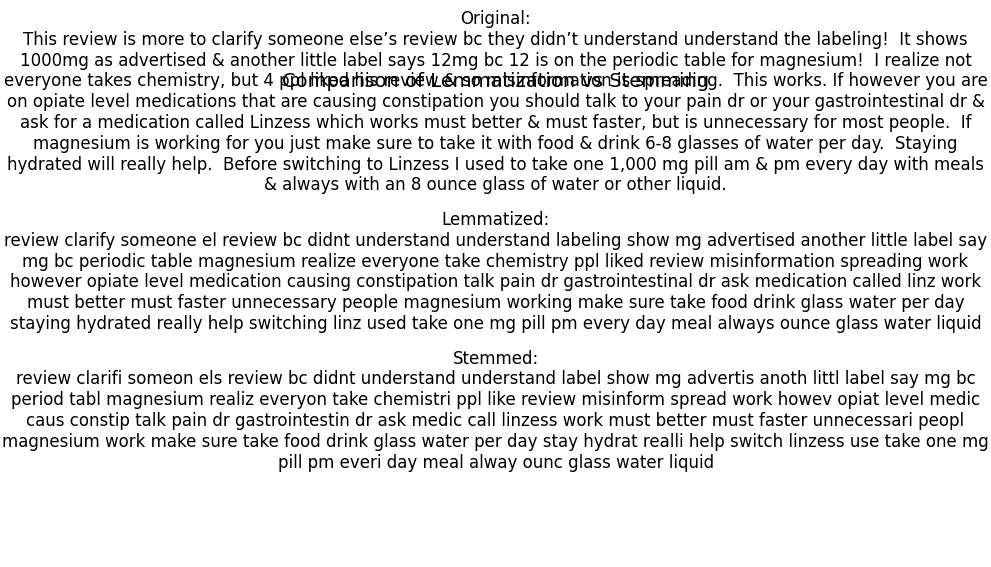

In [20]:
# Example text for comparison
example_text = df['text'].iloc[0] # First review text

# Preprocess the text with both methods
lemmatized_text = preprocess_text(example_text)
stemmed_text = stem_text(example_text)

# Plot the original, lemmatized, and stemmed text
fig, ax = plt.subplots(figsize=(10, 6))

# Original text
ax.text(0.5, 0.8, f"Original:\n{example_text}", fontsize=12, wrap=True, ha='center')
# Lemmatized text
ax.text(0.5, 0.5, f"Lemmatized:\n{lemmatized_text}", fontsize=12, wrap=True, ha='center')
# Stemmed text
ax.text(0.5, 0.2, f"Stemmed:\n{stemmed_text}", fontsize=12, wrap=True, ha='center')

# Remove axes and display plot
ax.axis('off')
plt.title('Comparison of Lemmatization vs Stemming', fontsize=14)
plt.show()

In [21]:
# Drop the original 'title' and 'text' columns after preprocessing
df = df.drop(columns=['title', 'text'])

## Sentiment labeling
Reviews were categorized into three sentiment classes based on their rating values:
Positive: ratings of 4.0 and above
Neutral: ratings between 2.0 and 4.0
Negative: ratings below 2.0


In [22]:
#Sentiment Labeling
def label_sentiment(rating):
    if rating >= 4.0:
        return 'positive'
    elif rating >= 2.0:
        return 'neutral'
    else:
        return 'negative'

df['sentiment'] = df['rating'].apply(label_sentiment)

## Save the cleaned data into a csv

In [23]:
# export to clean_data.csv
df.to_csv('clean_data.csv', index=False)

We can also download the data saved in a remote drive storage

In [24]:
# Google Drive file ID
file_id = "1wFCuWmi6B33Qttx-wKlDdt5ityRdkMH4"
# Create the Google Drive download link
download_url = f"https://drive.google.com/uc?id={file_id}"
# Download the CSV file
output_path = "amazon_reviews_clean.csv"
gdown.download(download_url, output_path, quiet=False)


Downloading...
From: https://drive.google.com/uc?id=1wFCuWmi6B33Qttx-wKlDdt5ityRdkMH4
To: /content/amazon_reviews_clean.csv
100%|██████████| 94.1M/94.1M [00:00<00:00, 190MB/s]


'amazon_reviews_clean.csv'

# Exploratory Data Analysis (EDA)

In [25]:
df.head(5)

,rating,timestamp,helpful_vote,verified_purchase,date,clean_title,clean_text,sentiment
0,4.0,1580950175902,3,True,2020-02-06 00:49:35.902,mg periodic table people mg magnesium,review clarify someone el review bc didnt unde...,positive
1,5.0,1604354586880,3,True,2020-11-02 22:03:06.880,save lanet using le plastic,love easy multitasking bleach tablet beat carr...,positive
2,5.0,1563966838905,0,True,2019-07-24 11:13:58.905,fantastic,suffering couple month heel pain plantar fasci...,positive
3,4.0,1662258542725,7,True,2022-09-04 02:29:02.725,hold water make bubble thats bought,cheap wanted massage function joke though come...,positive
4,1.0,1642722787262,0,True,2022-01-20 23:53:07.262,,didnt thing saying dont,negative


A bar plot was generated to display the distribution of sentiment labels, providing an overview of sentiment polarity within the dataset.

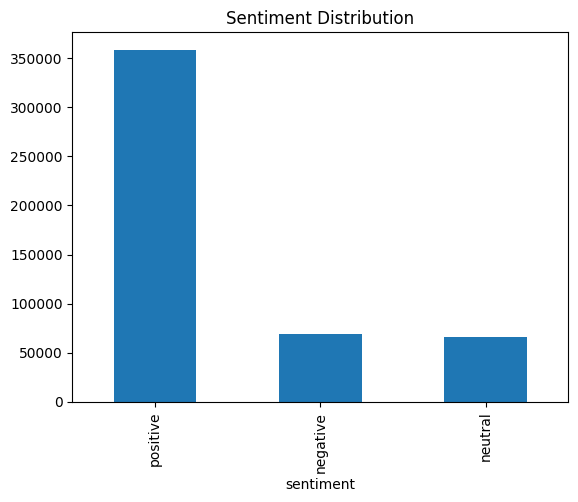

In [26]:
df['sentiment'].value_counts().plot(kind='bar', title='Sentiment Distribution')
plt.show()

To examine potential correlations between sentiment and helpfulness, the mean number of helpful votes for each sentiment category was calculated and visualized. This step aimed to understand if helpful votes indicate positive or negative reviews.

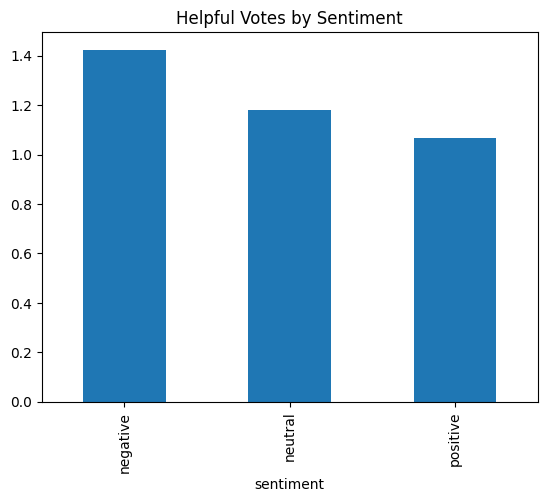

In [27]:
# Analyze if helpful votes have any correlation with positive or negative reviews.
df.groupby('sentiment')['helpful_vote'].mean().plot(kind='bar', title='Helpful Votes by Sentiment')
plt.show()

In [28]:
df[['rating', 'helpful_vote']].corr()

,rating,helpful_vote
rating,1.000000,-0.007774
helpful_vote,-0.007774,1.000000


In [29]:
# no correlation between rating and helpful votes drop the column helpful votes
df = df.drop(columns=['helpful_vote'])


# Wordcloud

Word clouds were generated for positive, neutral, and negative reviews by concatenating all clean_text values within each sentiment category. The word clouds highlighted the most common words associated with each sentiment, providing insights into the themes or language patterns unique to each class.

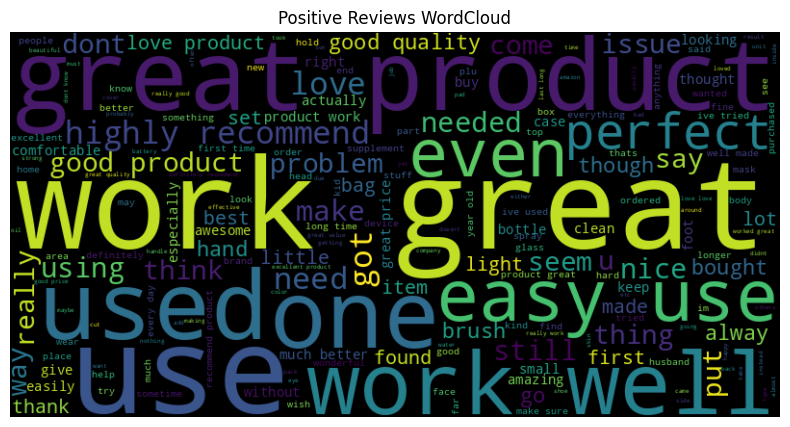

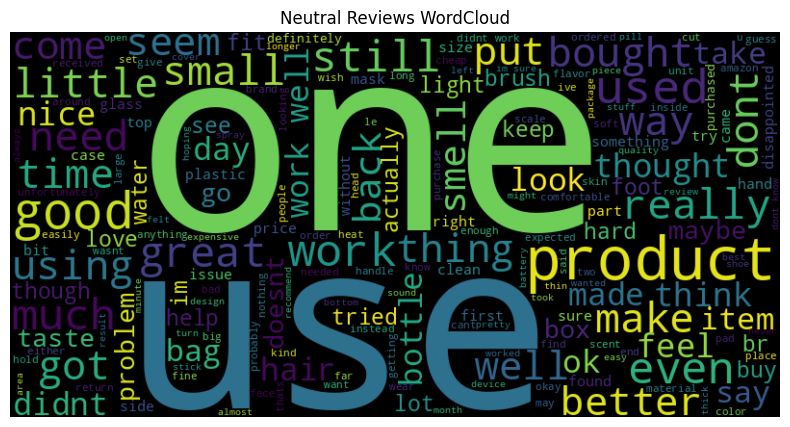

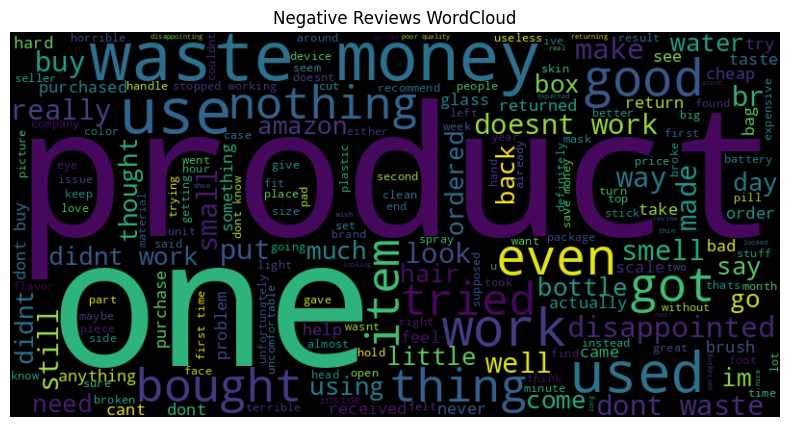

In [30]:
# Visualize common words in positive, neutral, and negative reviews using word clouds.

# Word cloud for positive reviews
positive_text = ' '.join(df[df['sentiment'] == 'positive']['clean_text'])
wordcloud_positive = WordCloud(width=800, height=400).generate(positive_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.axis('off')
plt.title('Positive Reviews WordCloud')
plt.show()

# Word cloud for neutral reviews
neutral_text = ' '.join(df[df['sentiment'] == 'neutral']['clean_text'])
wordcloud_neutral = WordCloud(width=800, height=400).generate(neutral_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_neutral, interpolation='bilinear')
plt.axis('off')
plt.title('Neutral Reviews WordCloud')
plt.show()

# Word cloud for negative reviews
negative_text = ' '.join(df[df['sentiment'] == 'negative']['clean_text'])
wordcloud_negative = WordCloud(width=800, height=400).generate(negative_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.axis('off')
plt.title('Negative Reviews WordCloud')
plt.show()

# Vectorizers

## Count Vectorizer

After preprocessing steps, we proceeded with vectorization firstly we implemented bag of words method and limited the count to 10,000 frequently appearing words and applied CountVectorizer method then we got the feature_names_out and created a datframe with words as columns and the documnets as rows this helped us  organize our vectorized data for subsequent analysis .

In [31]:
from sklearn.feature_extraction.text import CountVectorizer

# Applying CountVectorizer method
vectorizer = CountVectorizer(max_features=10000, max_df=0.95, min_df=2, stop_words='english')  # Limit to 10,000 most frequent words


# Fit and transform the clean_text column to create the Bag of words model
bag_of_words = vectorizer.fit_transform(df['clean_text'])

# Getting the word feature names
words = vectorizer.get_feature_names_out()

# Create a DataFrame with words as columns and documents as rows
bow_df = pd.DataFrame.sparse.from_spmatrix(bag_of_words, columns=words)

# Display the Bag of Words DataFrame
print(bow_df.head())

   aa  aaa  ab  abdomen  abdominal  ability  able  abnormal  aboutbr  abr  \
0   0    0   0        0          0        0     0         0        0    0   
1   0    0   0        0          0        0     0         0        0    0   
2   0    0   0        0          0        0     0         0        0    0   
3   0    0   0        0          0        0     0         0        0    0   
4   0    0   0        0          0        0     0         0        0    0   

   ...  ziploc  ziplock  zipped  zipper  zippered  zippo  zit  zombie  zone  \
0  ...       0        0       0       0         0      0    0       0     0   
1  ...       0        0       0       0         0      0    0       0     0   
2  ...       0        0       0       0         0      0    0       0     0   
3  ...       0        0       0       0         0      0    0       0     0   
4  ...       0        0       0       0         0      0    0       0     0   

   zoom  
0     0  
1     0  
2     0  
3     0  
4     0  

[

## TF-IDF

We also implemented the TFIDF vectorization technique: Term Frequency-Inverse Document Frequency. This gives us the importance of a word based on how rare it appears in the documents. Using the Sickit-learn TFIDFVectorizer, we first converted the words into numerical format. We created a DataFrame of the TFIDF- scores which we further used for our analysis and identified that it performs better than the Count Vectorizer

In [32]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Vectorize the 'clean_text' column
bow_vectorizer = TfidfVectorizer(max_features=10000)
tfidf = bow_vectorizer.fit_transform(df['clean_text'].fillna(''))  # Fill NaN with empty strings to avoid errors

# Get the words (features) from the vectorizer
words_tfidf = bow_vectorizer.get_feature_names_out()

# Convert the TF-IDF matrix to an array
#tfidf_array = tfidf.toarray()

# Create a DataFrame to visualize the TF-IDF scores for each document
tfidf_df = pd.DataFrame.sparse.from_spmatrix(tfidf, columns=words_tfidf)

# Display the first few rows of the TF-IDF matrix
tfidf_df.head()

,aa,aaa,ab,abdomen,abdominal,ability,able,abnormal,aboutbr,abr,...,ziploc,ziplock,zipped,zipper,zippered,zippo,zit,zombie,zone,zoom
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Classification

As we can see in the following code cells, the data is significantly unbalanced, which can lead the model to recognize better one compared than the others and bias the results towards the predominant class.

In [33]:
df['sentiment'].value_counts()

,count
sentiment,
positive,358528
negative,69542
neutral,65831


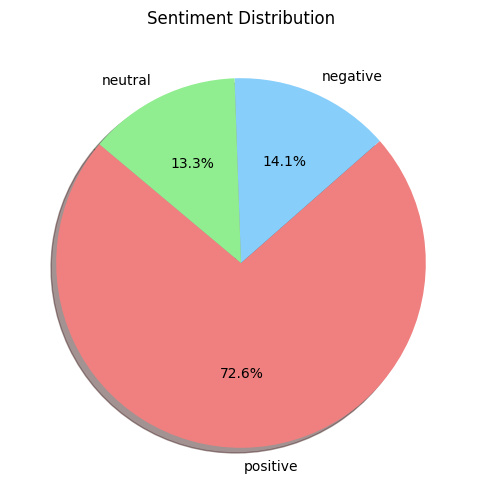

In [34]:
import matplotlib.pyplot as plt

# Get the count of each sentiment label
sentiment_counts = df['sentiment'].value_counts()

# Plot the pie chart
plt.figure(figsize=(8, 6))
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', startangle=140, colors=['lightcoral', 'lightskyblue', 'lightgreen'], shadow=True)
plt.title('Sentiment Distribution')
plt.show()

After the vectorization, we split the data into train and test sets with a distribution of 80-20 using Scikit-learn “TrainTestSplit.”

In order to perform the classification task with the vectorized data, we had to choose between the different multi-class classification models. We evaluated several criteria, such as interpretability, efficiency, and others, to select the most convenient for our use case. In the following sections, we discuss the characteristics of the two models selected for this problem in more detail.


## Logistic regression

We decided to start with a simple and efficient model to perform the classification task. Logistic regression is known for being easy to interpret as it provides coefficients that show the relationship between words and the target class, which in our case would be the sentiments (positive, negative and neutral).

Also, as our model is being trained with high-dimensional data, this model makes a good choice as it performs well in tasks such as text classification in which each word becomes a feature while being computationally efficient and having built-in regularization to prevent overfitting.

We set the model’s parameter “max_iter” to 1000, so the model will update the coefficients to search for the optimal weights for the logistic regression a maximum of 1000 times. The other parameters were set at their default values, as the regularizer (L2), “tol” equals to 1e-4 which indicates the tolerance stopping criteria or the threshold that indicates convergence, “multi_class” equals to “auto” which chooses a multinomial approach with the solver set as ‘lbfgs.’


### Using Bag of Words

In [35]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score


# Step 2: Splitting the data into training and testing sets
X_train_bow, X_test_bow, y_train, y_test = train_test_split(bow_df, df['sentiment'], test_size=0.2, random_state=42)

# Step 3: Training the Logistic Regression model
model = LogisticRegression(max_iter=1000)
model.fit(X_train_bow, y_train)

# Step 4: Making predictions
y_pred_lr_bow = model.predict(X_test_bow)

# Step 5: Evaluating the model
accuracy = accuracy_score(y_test, y_pred_lr_bow)
report = classification_report(y_test, y_pred_lr_bow, target_names=['negative', 'neutral', 'positive'])

print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:")
print(report)


Accuracy: 0.81
Classification Report:
              precision    recall  f1-score   support

    negative       0.67      0.58      0.63     13996
     neutral       0.49      0.24      0.33     13221
    positive       0.86      0.96      0.90     71564

    accuracy                           0.81     98781
   macro avg       0.67      0.59      0.62     98781
weighted avg       0.78      0.81      0.79     98781



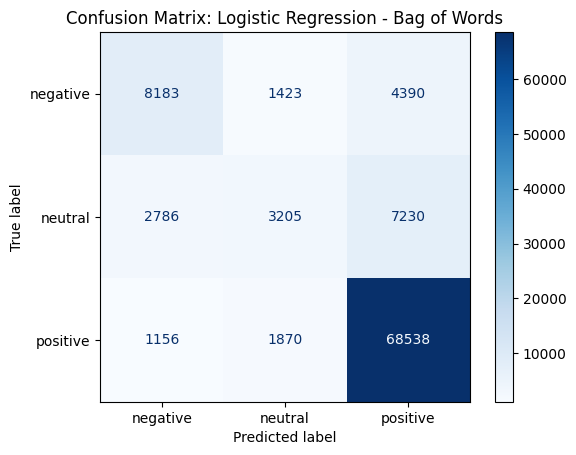

In [36]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm_logistic = confusion_matrix(y_test, y_pred_lr_bow)

disp_logistic = ConfusionMatrixDisplay(confusion_matrix=cm_logistic, display_labels=['negative', 'neutral', 'positive'])
disp_logistic.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix: Logistic Regression - Bag of Words')
plt.show()


 we can appreciate how the class imbalance is also quite noticeable in the results as the model easily classifies the Positive class, which is the more prevalent one, representing more than 70% of the total data in the dataset, and struggles with the lowest represented data that is the Neutral sentiment.


In [37]:
# Function to predict sentiment for new reviews
def predict_sentiment_BoW_LR(review_text):
    # Transform the new review using the same vectorizer
    review_bow = bow_vectorizer.transform([review_text])
    # Predict the sentiment using the trained model
    prediction = model.predict(review_bow)
    # Print the predicted sentiment
    print("Predicted sentiment for the new review:", prediction)

# Example usage
new_review = "The product works great and exceeded my expectations."
predicted_sentiment = predict_sentiment_BoW_LR(new_review)

Predicted sentiment for the new review: ['positive']


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


In [38]:
new_review =  "It was okay. Not what I was expecting though."
predicted_sentiment = predict_sentiment_BoW_LR(new_review)

Predicted sentiment for the new review: ['positive']


In [39]:
new_review = "I hate that product. Please don't buy it"
predicted_sentiment = predict_sentiment_BoW_LR(new_review)

Predicted sentiment for the new review: ['positive']


### Using TF-IDF

In [40]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

# Splitting the data into training and testing sets
X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(df['clean_text'].fillna(''), df['sentiment'], test_size=0.2, random_state=42)

# Fit the vectorizer on the training data
vectorizer_tfidf = TfidfVectorizer(max_features=10000)
X_train = vectorizer_tfidf.fit_transform(X_train_tfidf)

# Transform the test data using the fitted vectorizer
X_test = vectorizer_tfidf.transform(X_test_tfidf)

# Training the Logistic Regression model
model_tfidf = LogisticRegression(max_iter=200, solver='saga')  # Using 'saga' for large datasets
model_tfidf.fit(X_train, y_train)

# Making predictions
y_pred_tfidf = model_tfidf.predict(X_test)

# Evaluating the model
accuracy_tfidf = accuracy_score(y_test, y_pred_tfidf)
report_tfidf = classification_report(y_test, y_pred_tfidf, target_names=['negative', 'neutral', 'positive'])

print(f"Accuracy: {accuracy_tfidf:.2f}")
print("Classification Report:")
print(report_tfidf)


Accuracy: 0.82
Classification Report:
              precision    recall  f1-score   support

    negative       0.69      0.63      0.66     13996
     neutral       0.52      0.28      0.36     13221
    positive       0.87      0.96      0.91     71564

    accuracy                           0.82     98781
   macro avg       0.69      0.62      0.65     98781
weighted avg       0.80      0.82      0.80     98781



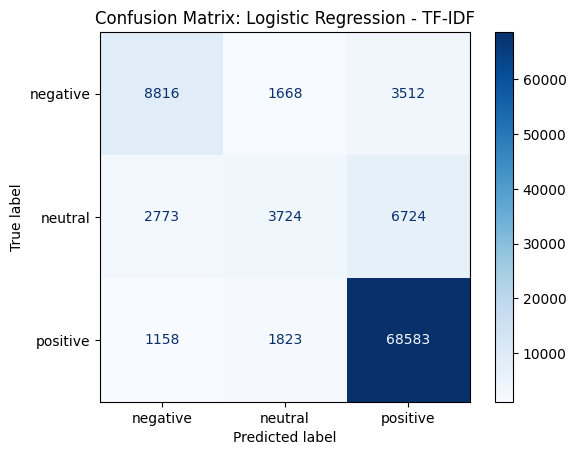

In [41]:
cm_logistic = confusion_matrix(y_test, y_pred_tfidf)

disp_logistic = ConfusionMatrixDisplay(confusion_matrix=cm_logistic, display_labels=['negative', 'neutral', 'positive'])
disp_logistic.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix: Logistic Regression - TF-IDF')
plt.show()

In [42]:
# Example text to classify
new_text = ["This product is amazing and I love using it every day!"]

def predict_sentiment_tfidf_LR(new_text):
    # Preprocess the text
    preprocessed_text = preprocess_text(new_text[0])

    # Transform the preprocessed text using the fitted vectorizer
    tfidf = vectorizer_tfidf.transform([preprocessed_text])

    # Make a prediction using the trained model
    predicted_label = model_tfidf.predict(tfidf)

    # Display the predicted sentiment
    predicted_sentiment = predicted_label[0]
    print(f"The predicted sentiment for the given text is: {predicted_sentiment}")

predict_sentiment_tfidf_LR(new_text)


The predicted sentiment for the given text is: positive


In [43]:
new_text = ["I hate that product. Please don't buy it"]
predict_sentiment_tfidf_LR(new_text)

The predicted sentiment for the given text is: negative


In [44]:
new_text = ["It was okay. Not what I was expecting though."]
predict_sentiment_tfidf_LR(new_text)

The predicted sentiment for the given text is: neutral


## Random Forest Classifier

On the other hand, we decided to train the data with a more robust model like Random Forest, which, unlike Logistic Regression, can capture non-linear relationships, which may improve performance in some cases. 

As it is an ensemble method, it reduces overfitting by combining multiple decision trees and, at the same time, is robust against imbalanced datasets for the same reason.

For this model, we set the “number of estimators” to 10; as the dataset is considerably large, training the model in a higher number of decision trees would result in higher computational times and memory usage, making 10 estimators an appropriate number that provides a good balance between model performance and training efficiency for a large dataset like the one used in the project with limited resources.


### Using Bag of Words

In [45]:
from sklearn.ensemble import RandomForestClassifier

# Training the Random Forest classifier for Bag of Words
rf_bow = RandomForestClassifier(n_estimators=10, random_state=42)
rf_bow.fit(X_train_bow, y_train)

# Predictions for Bag of Words
y_pred_bow = rf_bow.predict(X_test_bow)
print("Bag of Words - Random Forest")
print("Accuracy:", accuracy_score(y_test, y_pred_bow))
print("Classification Report:\n", classification_report(y_test, y_pred_bow))


Bag of Words - Random Forest
Accuracy: 0.7890383778256952
Classification Report:
               precision    recall  f1-score   support

    negative       0.60      0.57      0.58     13996
     neutral       0.42      0.22      0.28     13221
    positive       0.85      0.94      0.89     71564

    accuracy                           0.79     98781
   macro avg       0.62      0.57      0.59     98781
weighted avg       0.76      0.79      0.77     98781



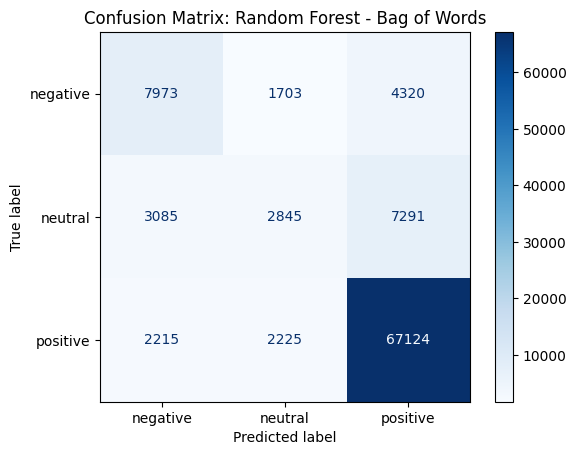

In [46]:
# For Random Forest
cm_rf = confusion_matrix(y_test, y_pred_bow)

disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=['negative', 'neutral', 'positive'])
disp_rf.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix: Random Forest - Bag of Words')
plt.show()

In [47]:
# Function to predict sentiment for new reviews
def predict_sentiment_BoW_RF(review_text):
    # Transform the new review using the same vectorizer
    review_bow = bow_vectorizer.transform([review_text])
    # Predict the sentiment using the trained model
    prediction = rf_bow.predict(review_bow)
    # Print the predicted sentiment
    print("Predicted sentiment for the new review:", prediction)

# Example usage
new_review = "The product works great and exceeded my expectations."
predicted_sentiment = predict_sentiment_BoW_RF(new_review)

Predicted sentiment for the new review: ['positive']


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [48]:
new_text = "I hate that product. Please don't buy it"
predict_sentiment_BoW_RF(new_text)
new_text = "It was okay. Not what I was expecting though."
predict_sentiment_BoW_RF(new_text)


Predicted sentiment for the new review: ['positive']
Predicted sentiment for the new review: ['positive']


In [49]:
# Fit the vectorizer on the training data
vectorizer_tfidf = TfidfVectorizer(max_features=10000)
X_train = vectorizer_tfidf.fit_transform(X_train_tfidf)

# Transform the test data using the fitted vectorizer
X_test = vectorizer_tfidf.transform(X_test_tfidf)
# Training the Random Forest classifier for TF-IDF
rf_tfidf = RandomForestClassifier(n_estimators=10, random_state=42)
rf_tfidf.fit(X_train, y_train)

# Predictions for TF-IDF
y_pred_tfidf = rf_tfidf.predict(X_test)
print("TF-IDF - Random Forest")
print("Accuracy:", accuracy_score(y_test, y_pred_tfidf))
print("Classification Report:\n", classification_report(y_test, y_pred_tfidf))


TF-IDF - Random Forest
Accuracy: 0.7982709225458338
Classification Report:
               precision    recall  f1-score   support

    negative       0.65      0.56      0.60     13996
     neutral       0.47      0.18      0.27     13221
    positive       0.84      0.96      0.90     71564

    accuracy                           0.80     98781
   macro avg       0.65      0.57      0.59     98781
weighted avg       0.76      0.80      0.77     98781



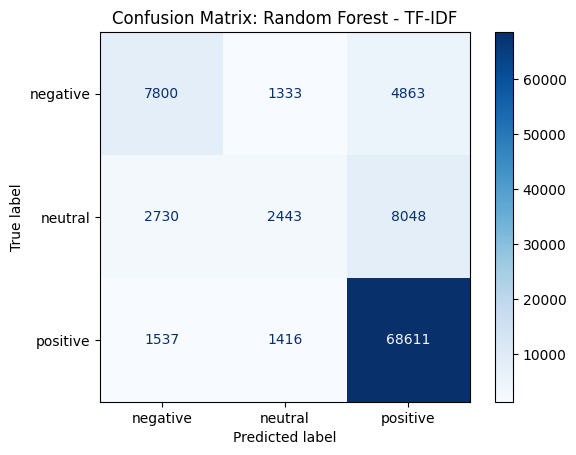

In [50]:
cm_rf = confusion_matrix(y_test, y_pred_tfidf)

disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=['negative', 'neutral', 'positive'])
disp_rf.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix: Random Forest - TF-IDF')
plt.show()

In [51]:

# Example text to classify
new_text = ["This product is amazing and I love using it every day!"]

def predict_sentiment_tfidf_RF(new_text):
    # Preprocess the text
    preprocessed_text = preprocess_text(new_text[0])

    # Transform the preprocessed text using the fitted vectorizer
    tfidf = vectorizer_tfidf.transform([preprocessed_text])

    # Make a prediction using the trained model
    predicted_label = rf_tfidf.predict(tfidf)

    # Display the predicted sentiment
    predicted_sentiment = predicted_label[0]
    print(f"The predicted sentiment for the given text is: {predicted_sentiment}")

predict_sentiment_tfidf_RF(new_text)



The predicted sentiment for the given text is: positive


In [52]:
new_text = ["I hate that product. Please don't buy it"]
predict_sentiment_tfidf_RF(new_text)

The predicted sentiment for the given text is: negative


In [53]:
new_text = ["It was okay. Not what I was expecting though."]
predict_sentiment_tfidf_RF(new_text)


The predicted sentiment for the given text is: neutral


# Summary

Overall, the results suggest that Logistic Regression using TF-IDF is the model that presents the best performance; even if the gains were not drastic, it achieved the highest scores for all the evaluated metrics compared to the Random Forest Classifier for both vectorization techniques. This indicates that the linear nature of this model can fit the data better for this specific dataset, possibly because the data is linearly separable.

 Also, the fact that TF-IDF improves performance for the two models indicates that this technique provides a more informative representation of the data than Bag of Words.



| Model                    | Vectorization | Precision (weighted avg) | Recall (weighted avg) | F1-Score (weighted avg) | Accuracy |
|--------------------------|---------------|---------------------------|------------------------|--------------------------|----------|
| Logistic Regression      | Bag of Words  | 0.78                      | 0.81                   | 0.79                     | 0.81     |
| Logistic Regression      | TF-IDF        | 0.80                      | 0.82                   | 0.80                     | 0.82     |
| Random Forest Classifier | Bag of Words  | 0.76                      | 0.79                   | 0.77                     | 0.79     |
| Random Forest Classifier | TF-IDF        | 0.76                      | 0.80                   | 0.77                     | 0.80     |


# Conclusions

* To conclude, we can say that the results presented in the models trained with the TF-IDF vectorization technique outperformed those who used the Bag of Words approach. The results for this technique surpassed the ones with BoW by about 1% in all the evaluation metrics for the two models and performed slightly better for the Logistic Regression model.

* Although the models trained didn’t show an overall good performance, there is a lot of potential to improve the model:
As the dataset presented a high class imbalance, the results are very biased to the most frequent class, representing more than 72% of the total data. Because of this, some measures can be taken to improve the models’ performance, such as upsampling or class weighting.

* There is also space for improvement in both the models used and the hyperparameter tuning; there are some other models that are worth trying as Support Vector Machine (SVM) that perform well in high dimensional spaces or deep learning models like LSTM or BERT, which can capture complex patterns but may require more computational power and require larger datasets in order to produce good results. Naive Bayes is also a good option due to its simplicity and speed.
